# CS x476 - Fall 2021
# Project 2: Segmentation with CNN

## Brief
* Due: Wednesday, 10/06/2021, 11:59PM

* Hand-in: through Gradescope
* Required files:
  * `<your_gt_username>.zip`
  * `<yout_gt_username>.pdf`
  
All projects in this course will be done with these jupyter notebooks. These are convenient ways for you to easily interact with your code. A notebook contains many blocks of code, each of which can be run independently.

There are multiple ways that you can run a cell:
1. Run the current cell, and stay in the current cell
  * `ctrl+enter` on Windows and Linux
  * `cmd+enter` on MacOS
2. Run the current cell, move to the next cell:
  * `shift+enter`
  * click the "Run" button in the tool bar


For this project we are going to focus on semantic image segmentation with a state-of-the-art approach: deep learning.

Basic learning objectives of this project:

- Basic segmentation
    - Understanding the goal of image segmentation.
    - Understanding sigmoid and softmax functions.
    - Applying segmentation masks to images.

- Architechture of segmentation model
    - Understanding Fully Convolutional Networks and its backbones (VGG-19 and ResNet-50)
    - Looking into feature maps generated at different parts of the network.

- Model performance
    - Understanding performance metrics like IoU.
    - Comparing performance for two different models
    
- Extra Credit
    - Understanding Pyramid Scene Parsing Network (PSPNet)
    - Comparing PSPNet andn FCN models. 

## Setup

In [2]:
import os
import math

import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List

In [2]:
# If you use Colab, please run this cell in Colab
# Otherwise, you can ignore this cell

# # First install these libs then run the following cells
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir
# !pip install torchinfo

# # Then unzip the zip file using code below
# !unzip <folder_name>.zip

In [3]:
# If you are using colab, you will need to run the above cell before run this cell

import albumentations
import segmentation_models_pytorch as smp

import student_code as student_code
import utils as utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Part 1: Image Segmentation

**Image segmentation** is a task in computer vision that divides an image into different sections based on the objects or boundaries in the image. This is done by classifying each pixel to belong to a particular class (in most cases these classes correspond to the types of objects that could exist in the image). The result of image segmentation is an image mask that labels each pixel belonging to the same class with the same value.

There are two types of segmentation tasks - **semantic segmentation** and **instance segmentation**. Semantic segmenation classifies all the pixels of an object category to the same class. For example, if the image has two cars in it, both of the cars will be assigned the same classification label. Instance segmentation differentiates between instances of the same object category in the image. For example, if the image has two cars in it, each car will be assigned a different classification label. In this project, we will be looking at semantic segmentation only.

Run the cell below to visualize 3 sample images in the CamVid dataset and their corresponding masks that depict the segmented image to recognize cars.

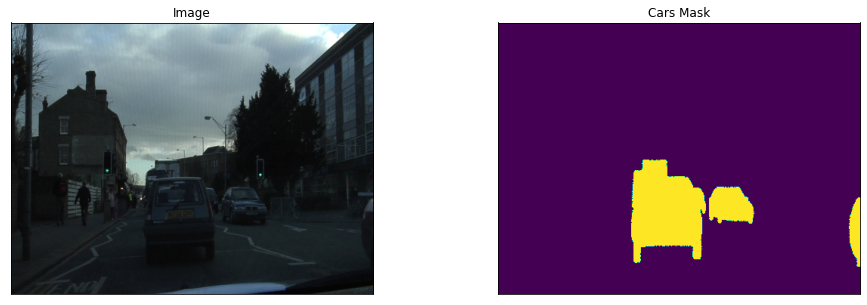

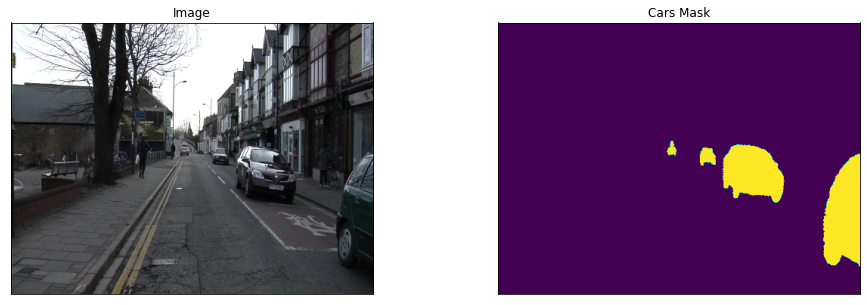

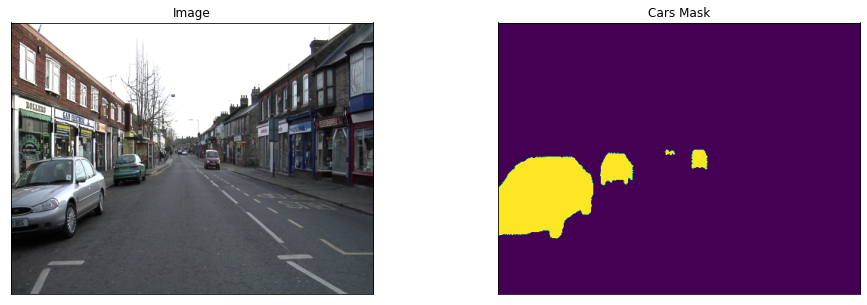

In [4]:
# Run the following cell and analyze the output
vis_dataset = student_code.create_vis_dataset()
vis_dataset.display()

### Sigmoid and Softmax 
<a href="https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/">Reference link</a>

When using segmentation to detect only one type of class ('car' in our example), the task can be thought of as binary classification of each pixel. For each pixel, we want to know the probability of it belonging to 'car' (yellow pixels) or it's corresponding negative class, 'not car' (purple pixels). The output value that is generated by a segmentation model may not reflect the answer to this question. For example, a pixel belonging to a car and located at (x1, y1) may output the value 800 and another pixel belong to a car and located at (x2,y2) may output the value 20. These values make it difficult to compute a suitable "loss" for the model, i.e., it cannot correctly quantify how far is it from the correct answer. So, the output value is passed through a `sigmoid` function which converts values to lie between 0 and 1. 

<img src="https://miro.medium.com/max/582/1*Xu7B5y9gp0iL5ooBj7LtWw.png" width=500 />

$$
\sigma(z) = \frac{e^z}{1 + e^z} = \frac{1}{1 + e^{-z}}
$$

Note that the sigmoid function maps a real number to a value between 0 and 1, i.e., $\sigma: \mathbb{R}\to [0,1]$ Now a value between 0 and 1 can be interpreted as the probability of the pixel belong to the class. Each pixel can be classified as 'car' if its probability value is more then 0.5 and 'not car' if its probability value is less than 0.5.

### TO-DO 1
Implement the `sigmoid` function in `student_code.py`. The function should be able to handle an array of real numbers. The output will be the sigmoid function applied to each of the inputs individually.  

In [5]:
x = torch.randn(5)
y = student_code.sigmoid(x)
print(f"x = {x}")
print(f"y = {y}")

x = tensor([ 0.4884,  1.0910, -0.2646, -0.3781,  0.2844])
y = tensor([0.6197, 0.7486, 0.4342, 0.4066, 0.5706])


In [6]:
from proj2_unit_tests.test_softmax_sigmoid import test_sigmoid
print("test_sigmoid: ", utils.verify(test_sigmoid))

test_sigmoid:  "Correct"


When using segmentation to detect multiple types of classes (for example in the image given below, some of the classes are car, pedestrian, tree, road), the task is multiclass classification of each pixel. In this we want our output values to be probabilities of the pixel belonging to each of the possible classes. 

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-46475-6_7/MediaObjects/419974_1_En_7_Fig1_HTML.gif" />

The output values are passed through a `softmax` function to get probability values that lie between 0 and 1. Note that for multiclass classification, the model will output an array of `C` values, where `C` is the number of classes, i.e., $S:\mathbf{R}^C \to {[0,1]}^C$. The `softmax` function maps each $i^{th}$value in this array to a probability value using the following formula:
$$
S(\mathbf{z})_i = \frac{e^{\mathbf{z}_i}}{\sum_{j=1}^C e^{\mathbf{z}_j}} = \frac{e^{\mathbf{z}_i}}{ e^{\mathbf{z}_1} + ... + e^{\mathbf{z}_j} + ... + e^{\mathbf{z}_C}}
$$
Observe that the sum of the values of the softmax equals 1.

### TO-DO 2
Implement the `softmax` function in `student_code.py`. The example given in the cell below corresponds to the case where there are 5 classes (`C=5`).

In [7]:
x = torch.randn(5)
y = student_code.softmax(x)
print(f"x = {x}")
print(f"y = {y}")
print(f"sum(y) = {torch.sum(y)}")

x = tensor([ 0.5356, -0.0941, -1.0166, -0.6970,  0.8509])
y = tensor([0.2935, 0.1564, 0.0622, 0.0856, 0.4023])
sum(y) = 1.0


In [8]:
from proj2_unit_tests.test_softmax_sigmoid import test_softmax
print("test_softmax: ", utils.verify(test_softmax))

test_softmax:  "Correct"


Back to the car segmentation task, the mask for the image is created from the pixels classfied as 'car' or 'not car' after passing through the `sigmoid` function. You now have to apply this mask to the original image to get the final image segmentation.

### TO-DO 3
Implement the function `apply_mask_to_image` in `student_code.py`. 

*Note: You may get a warning that states `"Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."` This is expected.*

In [11]:
from proj2_unit_tests.test_apply_mask import test_final_seg_range,test_final_seg_values

# Reads images from ./data/Camvid
x_test_dir = "./data/CamVid/test/"
y_test_dir = "./data/CamVid/testannot/"
dataset = utils.Dataset(x_test_dir, y_test_dir, classes=['car'])

# Let's look at the first (image,mask) in the dataset only
image, mask = dataset[0]

final_seg = student_code.apply_mask_to_image(image, mask)

# Unit Tests
print("test_final_seg_range: ", utils.verify(test_final_seg_range))
print("test_final_seg_values: ", utils.verify(test_final_seg_values))


# Visualize
utils.visualize(
    image=image, 
    cars_mask=mask.squeeze(),
    final_seg=final_seg,
)

torch.Size([3, 360, 480, 3])
torch.Size([360, 480, 3])
torch.Size([3, 360, 480, 3])
torch.Size([360, 480, 3])
test_final_seg_range:  "Correct"
torch.Size([3, 360, 480, 3])
torch.Size([360, 480, 3])


IndexError: too many indices for tensor of dimension 0

## Part 2: Architecture of an image segmentation model

### 2.1 Understanding FCN and "backbones"

Common architectures used for image segmentation are [Fully Convolutional Networks (FCNs)](https://arxiv.org/pdf/1411.4038.pdf).

#### Fully Convolutional Networks (FCNs)
**What is an FCN?** An example FCN from the [original paper](https://arxiv.org/pdf/1411.4038.pdf) is shown in the diagram below: 
<img src="https://paperswithcode.com/media/methods/new_alex-model.jpg" width="500"/>


FCN is a convolutional neural network (CNN) that employs solely locally connected layers such as convolutional layers, pooling layers and upsampling layers. The convolutional layers compute a nonlinear filter to perform convolutions on the data given a kernel and stride.  The kernel repeatedly slides over the input image, performing convolutions of its data with the computed filter. The stride defines the number of pixels the filter moves for each convolution. The result is what we call a feature map. The pooling layers are used to reduce the dimensions of the feature maps. The upsampling layers are used to transform the feature maps into an output of a larger size.

Please see [this article](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac)  which includes the picture below to better understand how convolutional layers work.

<img src="https://miro.medium.com/max/4800/1*p-_47puSuVNmRJnOXYPQCg.png" width=500/>

An FCN naturally operates on an input of any size, and produces an output of corresponding (possibly resampled) spatial dimensions.

*Please read through the previously linked FCN paper for more details on this type of deep learning network.*

#### Backbones
**Now, what is a backbone?** A backbone is an architectural element which defines how the convolutional layers in the encoder of the image segmentation model are arranged and how the convolutional layers in the decoder network should be built. 

A FCN contains one backbone, which is often a convolutional neural network (CNN) like VGG and ResNet.

<!-- <img src="https://www.researchgate.net/publication/343170165/figure/fig2/AS:916634155876355@1595554021892/Framework-of-FCN-architecture-17-Resnet-101-as-backbone-for-top-view-person.jpg" width=800 /> -->

*__In this project, the FCN that we will be using is a [Feature Pyramid Network (FPN)](https://arxiv.org/pdf/1612.03144v2.pdf).__*

*__And, the backbones that we will be demonstrating within the FPN are [**VGG-19**](https://arxiv.org/abs/1409.1556) and [**ResNet-50**](https://arxiv.org/abs/1512.03385).__* 

Here is a generalized diagram displaying what an FPN looking like with a backbone:

<img src="https://miro.medium.com/max/940/0*v_KWTZcaAw-DRxmv.png" width=700 />

The *encoder-decoder* structure is incorporated to efficiently learn to make dense predictions for per-pixel tasks like semantic segmentation. In this structure, the chosen backbone is used as the encoder, and the FPN has its own decoder that updates to correspond to the particular backbone being used. 

- The term _"encode"_ means "to convert information into a particular form." The encoder's job in a network is to take in the input, analyze its features, and encode the information from the input's most significant features into a smaller and compact representation.

- The term _"decode"_ means "to convert (a coded message) into intelligible language." Thus, the decoder's job is to make sense of the smaller, compact representation of the significant features from the encoder and convert it into an output that is more understandable, that output in this case being the segmentation mask representation of these significant features.

***In terms of image segmentation, the intuition behind FPN is to encode the image passing it through a CNN as it gets downsampled and then decode it back or upsample it to obtain the segmentation mask.***

### 2.2 VGG-19
Let's look at the architecture of the VGG-19 backbone first.

The architecture of VGG-19 as shown in the diagram below:

<img src="https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg" width=500/>


__What does the FPN+VGG-19 network look like?__

Well, we can get a more detailed summary of the FPN+VGG-19 model after loading the VGG-19 backbone into the FPN structure. To do , we will use the `segmentation_models_pytorch` package for image segmentation. Please see the [GitHub](https://github.com/qubvel/segmentation_models.pytorch) and the [Read The Docs Project Page](https://smp.readthedocs.io/en/latest/) for this package for more documnetation info. 

Run the following cell to load the VGG-19 backbone into the FPN structure. Notice that the activation function that we will use for this is `sigmoid` because we are doing single-class image segmentation. After our network is successfully loaded, we will then load in our pre-trained weights from the `models/` directory into the netwwork. After the network has defined weights, it is often referred to as a **model**. So, from this point forward, we will refer to the all laoded FCN+backbones as models.

In [ ]:
# create segmentation model with pretrained vgg-19
vgg19_model = smp.FPN(
    encoder_name='vgg19', 
    classes=1, 
    activation='sigmoid',
)
vgg19_model.load_state_dict(torch.load('./models/vgg19_best_model_weights.pt', map_location=torch.device('cpu')))

Now that we have our FPN+VGG-19 loaded, let's print out a summary of the overall model's architecture by running the cell below.

In [ ]:
print(student_code.print_model_summary(vgg19_model))

__The output printed above is the network summary of the FPN+VGG-19, including all convolutional layers, activation functions, segmentation blocks, etc. used in the encoder and decoder sections of the network.__

____________

###  Question 1:
The output shapes of each layer in the model's summary above are in the form of: 
- [*1, number of feature maps, image height (up and down), image width (across)*].

What do you notice about the image height and image width as you go through the _encoder_ of the FPN+VGG-19? 
What about the _decoder_ of the FPN+VGG-19? 

### Answer:

(please write your answer here and remember to put your answer into the report)



________________________________

Next, we want to run our test data through our FPN+VGG-19 model.

To do this, **the data must be preprocessed in a way specific to the backbone VGG-19.** This can be done by hand, but the `albumentations` Python library for image augmentation makes this very quick and simple to do. Please see the [GitHub](https://github.com/albumentations-team/albumentations) and the [official webiste](https://albumentations.ai/) for this package for more documnetation info.

Run the following cell to get the data pre-processing function specific to the VGG-19 backbone and apply that function to our test dataset.

In [ ]:
# gets the correct preprocessing function for the 'vgg19' network
preprocessing_fn = smp.encoders.get_preprocessing_fn('vgg19')

# apply the preprocessing function `preprocessing_fn` and image augmentations to test dataset
test_dataset = utils.Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=utils.get_validation_augmentation(), 
    preprocessing=utils.get_preprocessing(preprocessing_fn),
    classes=['car'],
)

# gather data into DataLoader for easy retrieval during testing
test_dataloader = torch.utils.data.DataLoader(test_dataset)

Now that our test dataset has been preprocessed to run through the VGG-19 backbone of the FPN+VGG-19 model, we can now see how well the pre-trained model performs!

Run the following cell to print out the predicted images segmentation mask for the images in out test dataset:

In [ ]:
for i in range(len(test_dataset)):
    image, true_mask = test_dataset[i]
    
    x_tensor = torch.from_numpy(image).to('cpu').unsqueeze(0)
    pred_mask = vgg19_model.predict(x_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy().round())

    utils.visualize(
        image=dataset[i][0],
        true_mask=true_mask.squeeze(), 
        pred_mask=pred_mask
    )

### 2.3 ResNet-50

**Now, let's look into the ResNet-50 backbone.**

The architecture of ResNet50 has 50 layers in total, organized into 4 large stages as shown in [this diagram](https://cdn-5f733ed3c1ac190fbc56ef88.closte.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png).

The ResNet-50 is composed of 4 different sections (each called a "layer"), named `layer1`, `layer2`, `layer3`, `layer4`. Each layer is composed of a repeated number of blocks, and each such block is named a "BottleNeck". Specifically, `layer1` has 3 Bottlenecks, `layer2` has 4 Bottlenecks, `layer3` has 6 Bottlenecks, and `layer4` has 3 Bottlenecks. In all, ResNet-50 has 16 Bottlenecks, which accounts for 48 of the conv layers.

__What does the FPN+ResNet-50 network look like?__

### **TO-DO 4**:
Implement the function `load_FPN_resnet50()` in `student_code.py` and run the following cell to see a network summary of the FPN+ResNet-50 network.

In [ ]:
resnet50_model = student_code.load_FPN_resnet50()

print(student_code.print_model_summary(resnet50_model))

_______
### Question 2:

What do you notice about the size of the FPN+ResNet-50 network/model in comparison with the FPN+VGG-19 network/model? What are other major differences that you notice between the two model architectures? (List at least 2.)

Now, make a prediction on which model you think will perform better and explain why?

### Answer:

(please write your answer here and remember to put your answer into the report)



________________________________

Now, we will pre-process the test data to work with the ResNet-50 backbone specifically using the same steps from `Section 2.2: VGG-19`. And, visualize the prediction results!

In [ ]:
# gets the correct preprocessing function for the 'vgg19' network
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50')

# apply the preprocessing function `preprocessing_fn` and image augmentations to test dataset
test_dataset = utils.Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=utils.get_validation_augmentation(), 
    preprocessing=utils.get_preprocessing(preprocessing_fn),
    classes=['car'],
)

# gather data into DataLoader for easy retrieval during testing
test_dataloader = torch.utils.data.DataLoader(test_dataset)

# Visualize ResNet-50 predictions
for i in range(len(test_dataset)):
    image, true_mask = test_dataset[i]

    x_tensor = torch.from_numpy(image).to('cpu').unsqueeze(0)
    pred_mask = resnet50_model.predict(x_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy().round())

    utils.visualize(
        image=dataset[i][0],
        true_mask=true_mask.squeeze(), 
        pred_mask=pred_mask
    )

### 2.4: Insight into feature maps
Now that we have visually seen how well both the FPN+VGG-19 and FPN+ResNet-50 predict, let's get a closer look at the learning process of both models by visualizing the feature maps that the models create at various convolutional layers throughout the networks.

In this section, we will be looking into the feature maps of the ResNet-50 network that you created in `Section 2.3`.

**For this section, you do not need to focus on understanding the code. Instead, focus on understanding the output of the code, i.e. the feature maps.** 

In [ ]:
feature_maps = {}
def get_feature_maps(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook
image, _ = test_dataset[0]
x_tensor = torch.from_numpy(image).to("cpu").unsqueeze(0) 

# Run the following cell and analyze the output
resnet50_model.encoder.conv1.register_forward_hook(get_feature_maps('conv1'))   
output = resnet50_model(x_tensor)

print("These are 64 of the feature maps (FMs) that the FPN+ResNet50 model creates in the first layer of its encoder:")
tmp = feature_maps['conv1']
plt.figure(figsize=(16, 16))
for i in range(tmp.shape[1]):
    n = tmp.shape[1]
    img = tmp[:,i,:,:]
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("FM #{}".format(i))
    plt.imshow(img.squeeze())

In [ ]:
# Run the following cell and analyze the output
resnet50_model.encoder.layer1[2].conv2.register_forward_hook(get_feature_maps('conv2'))  
output = resnet50_model(x_tensor)

print("These are 64 of the feature maps (FMs) that the FPN-ResNet50 model creates in the last layer of its encoder:")
tmp = feature_maps['conv2']
plt.figure(figsize=(16, 16))
for i in range(tmp.shape[1]):
    img = tmp[:,i,:,:]
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("FM #{}".format(i))
    plt.imshow(img.squeeze())

In [ ]:
# Run the following cell and analyze the output
resnet50_model.decoder.seg_blocks[3].block[0].block[0].register_forward_hook(get_feature_maps('seg_block3'))
    
output = resnet50_model(x_tensor)
print("These are 64 of the feature maps (FMs) that the FPN-ResNet50 model creates in the last layer of its decoder:")
tmp = feature_maps['seg_block3']
plt.figure(figsize=(16, 16))
for i in range(64):
    img = tmp[:,i,:,:]
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("FM #{}".format(i))
    plt.imshow(img.squeeze())

**The results above show what feature maps the FPN-ResNet50 model created to help it learn the dataset. Please make some notes on the major differences between the feature maps that the model produces above in the first layer of its encoder, the last layer of its encoder, and the last layer of its decoder. There will be critical thinking questions on the report about this.**

## Part 3: Compare Model Performance

To verify the predicted result, we use the Intersection over Union (IoU) method to measure the accuracy. Basically, we found out the overlapping area for two segments and divided by the union area of two segments. The funtion of Intersection over Union is IoU(A, B) = | A ∩ B | / | A U B |. As the result becomes closer to 1, the prediction segment and the ground truth segment are more similar. Here is one of the paper that you could read to gain more information about the IoU called [Generalized Intersection over Union](https://openaccess.thecvf.com/content_CVPR_2019/papers/Rezatofighi_Generalized_Intersection_Over_Union_A_Metric_and_a_Loss_for_CVPR_2019_paper.pdf)

_______
### Question 3:

Given the true mask and 2 different prediction results (Pred Mask1, Pred Mask2), which prediction result would have higher IoU score? Please Explain the reason. (If you can't load the picture in the notebook, you can view the picture in the `proj2_code` folder named `iou_question.png`.)

<img src="./iou_question.png" width=900/>

### Answer:

(please write your answer here and remember to put your answer into the report)



________________________________

### TODO 5: Implement the IoU
Implement the function `IoU()` in `student_code.py`.

In [ ]:
# Test your IoU implementation
from proj2_unit_tests.test_iou import test_IoU1, test_IoU2

print("test_IoU1(): ", utils.verify(test_IoU1))
print("test_IoU2(): ", utils.verify(test_IoU2))

After we have the correct IoU function, we could now use this to test out the performance of our models

### TODO 6: Apply IoU function
1) Implement the function `applyIoU()` in `student_code.py`.

2) Find out the IoU score for FPN-ResNet50 and FPN-VGG19

3) Record the IoU score for these 2 models into the report.

In [ ]:
vgg_iou = student_code.applyIoU(vgg19_model, test_dataset)
resnet_iou = student_code.applyIoU(resnet50_model, test_dataset)
print('vgg19 IoU score is: ',vgg_iou)
print('ResNet50 IoU score is: ', resnet_iou)

## Extra Credit: Pyramid Scene Parsing Network(PSPNet)
### (Optional for 4476 students, Required for 6476 students)

We'll not be implementing PSPNet for this project but instead, you will need to compare the performance between PSP and FCN in this notebook and answer correspoinding questions in the report.

If you want to Learn more about PSPNet, please check out this paper: https://arxiv.org/abs/1612.01105

### EC Part 1: Pyramid Pooling Module

After feeding an image through the CNN backbone and obtaining a feature map, PSPNet aggregates context over different portions of the image with the PPM.

The PPM splits the $H \times W$ feature map into KxK grids. Here, 1x1, 2x2, 3x3,and 6x6 grids are formed, and features are average-pooled within each grid cell. Afterwards, the 1x1, 2x2, 3x3, and 6x6 grids are upsampled back to the original $H \times W$ feature map resolution, and are stacked together along the channel dimension. These grids are visualized below (center):

<img src="https://user-images.githubusercontent.com/16724970/114436422-4b414a80-9b93-11eb-8f02-8e7506b5f9a1.jpg" width="900">

### EC Part 2: Compare Performance between PSP & FCN

### **TODO: EC**

In this section, you will need to compare the performance of the PSPNet architecture encoded with Resnet50 and the FCN architecture encoded with Resnet50. We keep the encoder to be the same so that we could see the performance difference between these two architecture. Recall that: *__in this project, the FCN that we will be using is a Feature Pyramid Network (FPN)__*. Thus, you have already implemented the FCN with 'resnet50' as the encoder in the early section, Section 2.3, you can just use the function here. 

Implement the `compare_psp_fpn` function in `student_code.py`. The step is below.

1) Load the FPN-ResNet50 from Part 2.3

2) Create an PSPNet using `segmentation_models_pytorch` with the encoder set as `resnet50` and the same activation function

3) Load the pre-trained weights in `models` folder

4) Find out the IoU score for FPN-ResNet50 and PSPNet-ResNet50

In [ ]:
psp_iou, fpn_iou = student_code.compare_psp_fpn(test_dataset)
print('PSPNet-ResNet50 IoU score is: ',psp_iou)
print('FPN-ResNet50 IoU score is: ', fpn_iou)

# Code Testing

We have provided a set of tests for you to evaluate your implementation. We have included tests inside `proj2.ipynb` so you can check your progress as you implement each section. When you're done with the entire project, you can call additional tests by running `pytest proj2_unit_tests` inside the `proj2_code` directory of the project. _Your grade on the coding portion of the project will be further evaluated with a set of tests not provided to you._

# Writeup

For this project (and all other projects), you must do a project report using the template slides provided to you at "proj2_template.pptx". Do <u>not</u> change the order of the slides or remove any slides, as this will affect the grading process on Gradescope and you will be deducted points. In the report you will describe your algorithm and any decisions you made to write your algorithm a particular way. Then you will show and discuss the results of your algorithm. The template slides provide guidance for what you should include in your report. A good writeup doesn't just show results--it tries to draw some conclusions from the experiments. You must convert the slide deck into a PDF with the name `<your_gt_username.pdf>` for your submission.

If you choose to do anything extra, add slides _after the slides given in the template deck_ to describe your implementation, results, and analysis. Adding slides in between the report template will cause issues with Gradescope, and you will be deducted points. You will not receive full credit for your extra credit implementations if they are not described adequately in your writeup. 

# Please check your assignment completion

### Required for all
* `sigmoid()`
* `softmax()`
* `apply_mask_to_image()`
* `load_FPN_resnet50()`
* `IoU()`
* `applyIoU()`


### Required for 6476 students, Optional for 4476 students
* `compare_psp_fpn()`


### Report
* Answer all the questions on the report correctly


### Note
* Lose 5 points for every time you do not follow the instructions for the hand-in format.


# Submission

This is very important as you will lose 5 points for every time you do not follow the instructions. 

Do <u>not</u> install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do <u>not</u> use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. 

Create the zip file using `python zip_submission.py --gt_username <your_gt_username>` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

Because we are not testing the implementation of the extra credit the coding portion, both 4476 and 6476 students should upload your python file to `proj2-code` assignment and report to `proj2-report` assignment in GradeScope.

# Credit
- Assignment developed by Kritika Gupta, Tongshu Yang, and Heyley Gatewood.<br/>